## Model Comparison 

The primary model I am using is the Long Short-Term Memory (LSTM) network because the input data (DNA sequences) are sequential. LSTMs are a recurrent neural network (RNN), which have improved the base model by remidying the "vanishing gradient problem" present in traditional RNNs (Hu et al., 2018). It aims to provide a short-term memory for RNN that can last thousands of timesteps, thus "long short-term memory".

In this research, I will compare the LSTM models to two others: a Convolutional Neural Network (CNN) and LaFleur et al.'s Multiple Linear Regression (MLR). CNNs are not as well suited for this dataset compared to a LSTM because CNNs are primarily used for grid-structured data like images. Although they can also be applied to sequential data by treating the data as a one-dimensional grid (e.g., for text classification tasks), CNNs do not inherently capture sequential dependencies as effectively as LSTMs (O'Shea and Nash, 2015). Lastly, I will also compare the models to LaFleur et al.'s MLR, which encodes the presence of each possible 3 nucleotide sequences within each hexamer (12).

I was was initially going to compare my LSTM to a MLR that one-hot encodes each of the six inputs as a different classification. However, this approach treats every unique sequence in each column as a separate categorical input. With 5 rows and 11942 columns, fitting a MLR model to this data would take an unrealistic amount of time and be very inaccurate. For this code, see "MLR.ipynb".

In [2]:
import pandas as pd
import numpy as np

In [3]:
# import dataset into a pandas data frame

df = pd.read_csv('41467_2022_32829_MOESM5_ESM.csv')
df.head()

,ID,DNA1 [counts],DNA2 [counts],DNA3 [counts],RNA1 [counts],RNA2 [counts],RNA3 [counts],TX1 [au],TX2 [au],TX3 [au],...,high quality,Observed log(TX/Txref),Predicted log(TX/Txref),dG10,dG35,dGDisc,dGITR,dGEXT10,dGSPAC,dGUP
0,0,8263,7261,5173,16341,10320,13506,2.258071,1.523795,1.545541,...,Yes,-3.386326,-3.844827,-1.781524,-1.477218,-0.106428,-0.021112,0.191352,-0.0924,0.400862
1,1,5600,4886,3264,10986,7250,10800,2.240001,1.590845,1.958709,...,Yes,-3.503140,-3.905283,-1.781524,-1.477218,-0.166884,-0.021112,0.191352,-0.0924,0.400862
2,2,7898,6790,4752,19572,32204,30585,2.829533,5.084911,3.810029,...,Yes,-4.207206,-3.905283,-1.781524,-1.477218,-0.166884,-0.021112,0.191352,-0.0924,0.400862
3,3,10651,9875,6466,15734,16246,18908,1.686729,1.763814,1.731036,...,Yes,-3.392439,-3.877808,-1.781524,-1.477218,-0.139409,-0.021112,0.191352,-0.0924,0.400862
4,4,12188,10793,6965,28609,21796,26803,2.680198,2.165100,2.278025,...,Yes,-3.698903,-3.672384,-1.781524,-1.477218,0.066015,-0.021112,0.191352,-0.0924,0.400862


In [4]:
# All input and output data

X = df[['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']]
y = df['Observed log(TX/Txref)']

X.head()

,UP,h35,spacs,h10,disc,ITR
0,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CCCCGCGG,CTCTACCTTAGTTTGTACGTT
1,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGCGGCGG,CTCTACCTTAGTTTGTACGTT
2,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGCGCCCG,CTCTACCTTAGTTTGTACGTT
3,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,GCGGCGGC,CTCTACCTTAGTTTGTACGTT
4,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGGGGGGC,CTCTACCTTAGTTTGTACGTT


In [5]:
# Function to one-hot encode DNA sequences

def one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1]}
    encoding = []
    for nucleotide in sequence:
         encoding += [mapping[nucleotide]]
    return encoding

## Approaches to Handling Variable-Length Inputs
There are six input sequences:
1. upstream 6-nucleotide site called the −35 motif
2. downstream 6-nucleotide site called the −10 motif
3. the 20-nucleotide region that appears upstream of the −35 motif, called the UP element
4. the spacer region that separates the −10 and −35 motifs
5. the typically 6-nucleotide region in between the −10 motif and TSS, called the discriminator (Disc)
6. the first 20 transcribed nucleotides, called the initial transcribed region (ITR)23

The upstream −35 motif and the downstream −10 motif are both 6 base pairs long. Every other sequence varies in length. There are no simple ways to train convolutional neural networks on multiple varying-length inputs. Here, I try two approaches to optimize MSE:
1. Only train the model on the upstream −35 motif and the downstream −10 motif.
2. Apply padding to some or all of the variable inputs.

In [6]:
# stores the various input approaches
X_dict = {}

# stores split training/testing
train_test = {}

# stores the results
results = {}

# stores the models
models = {}

# stores the model history
model_history = {}

## Approach 1: Only Including Fixed-Length Sequences

The upstream −35 motif and the downstream −10 motif are both 6 base pairs long. Concatenating them together gives us an input with non-variable length. This is the simpler approach, and ignores the complexity of including variable-length inputs. However, the upstream −35 motif and the downstream −10 motif are the promoter sequences, and should have a large effect on the transcription rates.

In [8]:
# Concatenate the one-hot encoded h35 + h10 sequence motifs
X_dict['h35_h10'] = np.array([one_hot_encode(h35 + h10) for h35, h10 in zip(df['h35'], df['h10'])])

# The first entry for this approach, one-hot encoded from 'TTGACATATAAT'
X_dict['h35_h10'][0]

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

In [10]:
# split the data in training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dict['h35_h10'], y, test_size=0.2, random_state=1, shuffle=True)
train_test['h35_h10'] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}


In [9]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [10]:
def build_model(current_model):
    # Define RNN model architecture
    models[current_model] = Sequential()
    models[current_model].add(LSTM(64, input_shape=X_dict[current_model].shape[1:])) # dynamically generated input shape based on X data
    models[current_model].add(Dense(1, activation='linear'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    models[current_model].compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = models[current_model].fit(train_test[current_model]['X_train'],
                                    train_test[current_model]['y_train'],
                                    epochs=150,
                                    batch_size=32,
                                    validation_data=(X_test, y_test),
                                    callbacks=[early_stopping])

    # Evaluate the model
    loss = models[current_model].evaluate(train_test[current_model]['X_test'], train_test[current_model]['y_test'])

    return models[current_model], loss, history

In [14]:
# Call the function to build the model, save the model, and store the results

m = 'h35_h10'

models[m], results[m], model_history[m] = build_model(m)
models[m].save(m + '.keras')

Epoch 1/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2557 - val_loss: 0.3109
Epoch 2/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3323 - val_loss: 0.2493
Epoch 3/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2427 - val_loss: 0.2104
Epoch 4/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2230 - val_loss: 0.2417
Epoch 5/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2240 - val_loss: 0.2015
Epoch 6/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2163 - val_loss: 0.2033
Epoch 7/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2192 - val_loss: 0.2158
Epoch 8/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2184 - val_loss: 0.1988
Epoch 9/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2178 - val_loss: 0.2015
Epoch 10/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2166 - val_loss: 0.2023
Epoch 11/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2137 - val_loss: 0.2007
Epoch 12/150
337/337 ━━━━━━━━━━━━━━━━━━━━

## Implimenting a Convolutional Neural Network

Next, we can train a CNN on the same data as before. We should see that the CNN performs marginally worse as it is not as well suited for this dataset compared to an LSTM. This is because CNNs are primarily used for grid-structured data like images instead of sequential inputs. Although they can also be applied to sequential data by treating the data as a one-dimensional grid (e.g., for text classification tasks), CNNs do not inherently capture sequential dependencies as effectively as LSTMs (O'Shea and Nash, 2015). 

I am extrapolating these results to the next LSTM, which is far more taxing and takes longer to train. Although the CNN will should improve given more data, it will not improve more than the LSTM.

In [17]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Define CNN model architecture
models['CNN'] = Sequential()
models['CNN'].add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_dict['h35_h10'].shape[1:]))
models['CNN'].add(MaxPooling1D(pool_size=2))
models['CNN'].add(Conv1D(filters=64, kernel_size=3, activation='relu'))
models['CNN'].add(MaxPooling1D(pool_size=2))
models['CNN'].add(Flatten())
models['CNN'].add(Dense(64, activation='relu'))
models['CNN'].add(Dense(1, activation='linear'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
models['CNN'].compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = models['CNN'].fit(train_test['h35_h10']['X_train'],
                                    train_test['h35_h10']['y_train'],
                                    epochs=150,
                                    batch_size=32,
                                    validation_data=(X_test, y_test),
                                    callbacks=[early_stopping])

# Evaluate the model
loss = models['CNN'].evaluate(train_test['h35_h10']['X_test'], train_test['h35_h10']['y_test'])

results['CNN'] = loss
model_history['CNN'] = history
models['CNN'].save('CNN.keras')


Epoch 1/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8390 - val_loss: 0.2189
Epoch 2/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2189 - val_loss: 0.2000
Epoch 3/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2044 - val_loss: 0.1907
Epoch 4/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2033 - val_loss: 0.1894
Epoch 5/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2033 - val_loss: 0.1891
Epoch 6/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1989 - val_loss: 0.1915
Epoch 7/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1971 - val_loss: 0.1964
Epoch 8/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1968 - val_loss: 0.1938
Epoch 9/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2008 - val_loss: 0.1945
Epoch 10/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1946 - val_loss: 0.1948
Epoch 11/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1926 - val_loss: 0.1948
Epoch 12/150
337/337 ━━━━━━━━━━━━━━━━━━━━

### Approach 2: Padding

Padding makes all the inputs equal in length by adding layers of zeros or other "filler" data outside the actual data in an input matrix. The primary purpose of padding is to preserve the spatial size of the input so that the output, after applying filters (kernels), remains the same size or adjusts according to the desired output dimensions (deepai.org, n.d.).

Padding is a preprocessing step applied to the LSTM or CNN before performing the convolution operation. During backtracking, the weight of padding data decreases accordingly, allowing the network to be able to read any necessary information from the input border areas.
According to Reddy and Reddy (2019), there is little difference in performance between pre-and post-padding in LSTMs, unlike with CNNs. However, they did find that LSTM pre-padding was marginally more accurate (5), so the padding will go upstream (before) the data. Additionally, I excluded the spacer sequence ('spacs' column) with lengths other than 16, 17, or 18. The other sequences have been synthetically developed and vary with a length from 0 to 31. This large standard deviation does not help produce more accurate results and only increases runtime.

According to Reddy and Reddy (2019), there is little difference in performance between pre-and post-padding in LSTMs, unlike with CNNs. However, they did find that LSTM pre-padding was marginally more accurate (5), so the padding will go upstream (before) the data. For a more comprehensive comparison, see "padding_comparison.ipynb". Additionally, I excluded the spacer sequence ('spacs' column) with lengths other than 16, 17, or 18. The other sequences have been synthetically developed and vary with a length from 0 to 31. This large standard deviation does not help produce more accurate results and only increases runtime.

My worry for using padding is that the model will fit trends to padding and that with such large inputs the model will have a difficult time identifying the most important features.

In [11]:
# lengths the values in each X column

for col in X.columns:
    seen = set()
    for each in X[col]:
        seen.add(len(str(each)))
    print(col, seen)

UP {16, 20, 22}
h35 {6}
spacs {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
h10 {6}
disc {8, 6, 7}
ITR {20, 21}


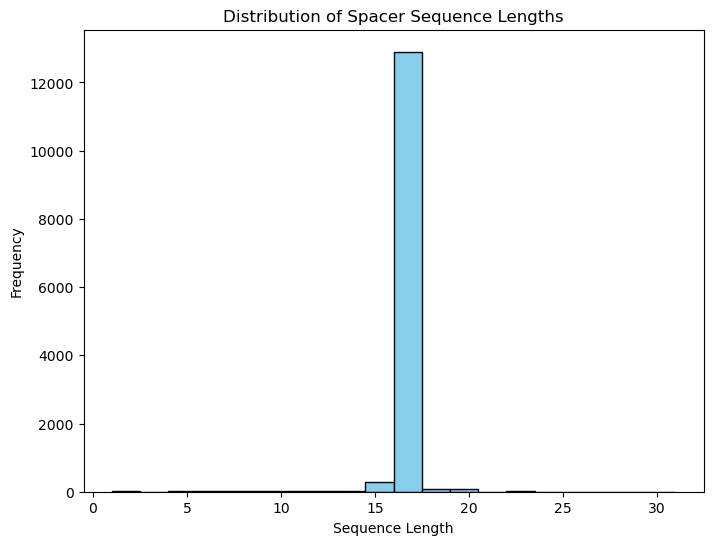

In [19]:
# Graph the distribution of Spacer sequence lengths

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(X['spacs'].apply(len), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Spacer Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [20]:
# remove all rows with spacer sequences that are not 16-18 nucleotides long


_df = df[(df['spacs'].str.len() >= 16) & (df['spacs'].str.len() <= 18)]


X = _df[['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']]
y = _df['Observed log(TX/Txref)']

print(f'Removed {df.shape[0] - _df.shape[0]} rows')


Removed 508 rows


In [12]:
# Function to one-hot encode DNA sequences, including padding 0's

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0,0], 'C': [0,1,0,0,0], 'G': [0,0,1,0,0], 'T': [0,0,0,1,0], '0': [0,0,0,0,1]}
    encoding = []
    for nucleotide in sequence:
         encoding += [mapping[nucleotide]]
    return encoding

In [13]:
upstream_padding = {}

for col in X.columns:
    max_len = X[col].apply(len).max()
    upstream_padding[col] = np.array([padded_one_hot_encode('0' * (max_len - len(seq)) + seq) for seq in X[col]])

# Concatenate the one-hot encoded, upstream-padded sequences
X_dict['upstream_padding'] = np.concatenate([upstream_padding[col] for col in X.columns], axis=1)
X_dict['upstream_padding'].shape

(13481, 94, 5)

In [14]:
# split the data in training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dict['upstream_padding'], y, test_size=0.2, random_state=1, shuffle=True)
train_test['upstream_padding'] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

In [29]:
# Call the function to build the model, save the model, and store the results

m = 'upstream_padding'

models[m], results[m], model_history[m] = build_model(m)
models[m].save(m + '.keras')

Epoch 1/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.3312 - val_loss: 0.7525
Epoch 2/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.4052 - val_loss: 0.2461
Epoch 3/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2618 - val_loss: 0.2684
Epoch 4/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2633 - val_loss: 0.2354
Epoch 5/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2353 - val_loss: 0.2302
Epoch 6/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2284 - val_loss: 0.2289
Epoch 7/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2375 - val_loss: 0.2414
Epoch 8/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2302 - val_loss: 0.2292
Epoch 9/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2217 - val_loss: 0.2203
Epoch 10/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2224 - val_loss: 0.2225
Epoch 11/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2279 - val_loss: 0.2198
Epoch 12/150
325/325 ━━━━━━━━━

## Evaluating LaFleur et al.'s Multiple Linear Regression Model

In [30]:
# remove all but 'Observed log(TX/Txref)' and 'Predicted log(TX/Txref)' columns

df_eval = df[['Observed log(TX/Txref)', 'Predicted log(TX/Txref)']]
df_eval.head()

,Observed log(TX/Txref),Predicted log(TX/Txref)
0,-3.386326,-3.844827
1,-3.503140,-3.905283
2,-4.207206,-3.905283
3,-3.392439,-3.877808
4,-3.698903,-3.672384


In [31]:
# evaluate using mean squared error and mean absolute error for LaFleur et al.'s model

from sklearn.metrics import mean_squared_error

results['LaFleur'] = mean_squared_error(df_eval['Observed log(TX/Txref)'], df_eval['Predicted log(TX/Txref)'])

print(f"MSE: {results['LaFleur']}")

MSE: 0.2514652958788732


In [32]:
# round the MSE of each model to 2 decimal places, then display the results

df_results = pd.DataFrame(results, index=['MSE'])
df_results = df_results.applymap(lambda x: round(x, 3))
df_results.head()

,h35_h10,CNN,upstream_padding,LaFleur
MSE,0.166,0.189,0.143,0.251


## Conclusion

Compared to LaFleur et al.'s Multiple Linear Regression model, both Long Short-Term Memory models performed far better. Only including fixed-length inputs, the upstream −35 motif, and the downstream −10 motif still decreased the mean-squared error from 0.251 to 0.167. These were good predictors of transcription rate as are both are the promoter sequences. This is the simpler approach, but it ignores the complexity of including variable-length inputs. 

Adding padding to the data to include all DNA sequences decreased the mean squared error to 0.143. Padding makes all the inputs equal in length by adding layers of zeros or other "filler" data outside the actual data in an input matrix. The primary purpose of padding is to preserve the spatial size of the input so that the output, after applying filters (kernels), remains the same size or adjusts according to the desired output dimensions (deepai.org, n.d.).

Padding is a preprocessing step applied to the LSTM or CNN before performing the convolution operation. During backtracking, the weight of padding data decreases accordingly, allowing the network to be able to read any necessary information from the input border areas.
According to Reddy and Reddy (2019), there is little difference in performance between pre-and post-padding in LSTMs, unlike with CNNs. However, they did find that LSTM pre-padding was marginally more accurate (5), so the padding will go upstream (before) the data. Additionally, I excluded the spacer sequence ('spacs' column) with lengths other than 16, 17, or 18. The other sequences have been synthetically developed and vary with a length from 0 to 31. This large standard deviation does not help produce more accurate results and only increases runtime.


## Future Work

For the best results, one should optimize the LSTM with the following hyperparameters: the neurons, layers, learning rate, batch size, and epochs. However, even randomized-search hyperparameter tuning is too taxing and time-intensive for my computer. In the future, I will perform hyperparameter tuning to better optimize the model. To reach robust performance results with non-parametric models, their respective hyperparameters must be optimized. Default hyperparameter settings cannot guarantee an optimal performance of machine-learning techniques, and additional attention should be directed to this critical step (Schratz et al., 2019). To do this, one should design their model to objectively search different values for model hyperparameters and choose a subset that results in a model that achieves the best performance on a given dataset (Brownlee 2020). Two common implementations for hyperparameter tuning are "randomized search" and "grid search." While grid search finds the more optimal hyperparameter, randomized search is far less taxing regarding time and processing power (Brownlee 2020). For LSTM, there are several hyperparameters to optimize.

**Number of LSTM Neurons:** Increasing the number of neurons per hidden layer will increase the complexity of the model. This will, in turn, improve accuracy, so long as it does not over-fit the data.

**Number of Layers:** Increasing the hidden layers will similarly increase how "deep" the model is. Past a few hidden layers, the model will become "blackboxed," and one will not be able to conclude meaningful relationships from it. However, this will again increase accuracy so long as it does not overfit the data.

**Learning Rate (alpha):** The learning rate is a tuning parameter in the gradient descent optimization algorithm. It determines the step size at each iteration while moving toward a minimum loss function. Increasing the learning rate will increase the model's training speed and convergence, but if it is too high, the algorithm will overstep and not converge.

**Batch Size:** Batches are the samples used during each epoch to update the model's weights. Smaller batch sizes can lead to faster convergence but might be less stable. Larger batch sizes may provide more stable updates but require more memory. Experiment with different batch sizes to find the optimal balance.

**Number of Epochs (Not Tuned):** The number of epochs determines how many times the model is trained with one forward and one backward propagation. Too few epochs lead to underfitting; likewise, too many lead to overfitting. The number of epochs should only set as the upper bound. Ideally, the model stops itself when it reaches a minimum MSE.

See "tuning.ipynb" for more on randomized-search hyperparameter tuning.

## Work Cited

Brownlee, Jason. “Hyperparameter Optimization with Random Search and Grid Search.” MachineLearningMastery.Com, 18 Sept. 2020, machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/.

LaFleur, Travis L., et al. “Automated Model-Predictive Design of Synthetic Promoters to Control Transcriptional Profiles in Bacteria.” Nature News, Nature Publishing Group, 2 Sept. 2022, www.nature.com/articles/s41467-022-32829-5.

“Padding (Machine Learning).” DeepAI, DeepAI, 17 May 2019, deepai.org/machine-learning-glossary-and-terms/padding.

Reddy, Mahidhar Dwarampudi, and Subba Reddy. “Effects of Padding on Lstms and CNNS.” arXiv.Org, 18 Mar. 2019, arxiv.org/abs/1903.07288.

Russell, Peter J. IGenetics. Benjamin Cummings, 2006. 